# Adathalmaz leírása

A vizsgált csoport három különböző búzafajta (*Kama*, *Rosa* és *Canadian*) szemcséiből állt, mindegyikből **70 mintát** választottak ki véletlenszerűen a kísérlethez.

A szemek belső szerkezetének magas minőségű megjelenítését egy **lágy röntgensugaras technikával** végezték. Ez a módszer:

- Roncsolásmentes
- Jelentősen olcsóbb, mint más fejlettebb képalkotó technikák, például a pásztázó mikroszkópia vagy lézeres technológia

A felvételeket **13x18 cm-es KODAK röntgenlemezeken** rögzítették.

A vizsgálatokat kombájnnal betakarított búzaszemekkel végezték, amelyek a **Lengyel Tudományos Akadémia Agrofizikai Intézetének** (Lublin) kísérleti földjeiről származtak.

> Az adathalmaz **klasszifikációs** (osztályozási) és **klaszterezési** (csoportosítási) feladatokra is alkalmas.

---

# Attribútumok

A búzaszemekről hét geometriai jellemzőt mértek:

1. **Terület** (`area`, *A*)
2. **Kerület** (`perimeter`, *P*)
3. **Kompaktság (Búzaszem alakja)**  
   `compactness = (4 * π * A) / P²`
4. **A szem hosszúsága** (`length of kernel`)
5. **A szem szélessége** (`width of kernel`)
6. **Aszimmetria együttható (mennyire szimmetrikus a búzaszem)** (`asymmetry coefficient`)
7. **Barázda hosszúsága** (`length of kernel groove`)

- Minden fenti attribútum **folytonos, valós számértékű**.

8. **Osztályozási címke** (`classification`) – a búzafajta neve:  
   `Kama`, `Rosa` vagy `Canadian`


### Használt könyvtárak és modulok

Az elemzés során az alábbi könyvtárakat és modulokat használtam:

- **Pandas** és **NumPy**: Az adatkezeléshez és numerikus számításokhoz.
- **Matplotlib** és **Seaborn**: Vizualizációk készítéséhez, beleértve az adatpontok, regressziók és a Confusion Matrix megjelenítését.  
  - **mpl_toolkits.mplot3d (Axes3D)**: 3D ábrák létrehozásához.
- **Scikit-learn**: Adatelőkészítésre, modellezésre és kiértékelésre, többek között:
  - **KMeans** és **DBSCAN**: Klaszterezési algoritmusok.
  - **LinearRegression** és **LogisticRegression**: Lineáris és logisztikus regressziók.
  - **RandomForestClassifier** és **GradientBoostingClassifier**: Ensemble osztályozók.
  - **train_test_split**: Adatok felosztása tanuló- és tesztadatokra.
  - **StandardScaler**: A numerikus jellemzők standardizálása.
  - **accuracy_score**, **f1_score**, **confusion_matrix**, **classification_report**, **r2_score**: A modellek teljesítményének kiértékelésére szolgáló metrikák.
- **TensorFlow Keras**: Neurális háló építésére és tanítására.
  - **Sequential**: Egymásra épülő rétegek egyszerű modellje.
  - **Dense** és **Dropout**: Teljesen kapcsolt rétegek és dropout réteg a regulárizációhoz.
  - **to_categorical**: Kategóriacímkék one-hot kódolása.
  - **EarlyStopping**: A tanítás korai leállítása a túlillesztés elkerülésére.


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report,r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


# Adatbetöltés és előfeldolgozás

## 1. Adatok betöltése

Az adatokat a `data_16.csv` fájlból töltöttem be a `pandas` könyvtár segítségével. A fájl első sora nem tartalmaz hasznos információt, ezért azt kihagytam a `skiprows=1` paraméter segítségével. Az oszlopneveket manuálisan adtam meg.


In [44]:
df = pd.read_csv('adatok/data_16.csv', skiprows=1, names=['terulet', 'kerulet', 'kompaktsag', 'szemhossz', 'szem_szelesseg',
                                      'asszimetria_egyutthato', 'barazdahossz', 'osztalycimke'])

## 2. Osztálycímkék átnevezése

Bevezettem a `buza_fajtaja` nevű oszlopot, hogy az `osztalycimke` numerikus értékeit szöveges kategóriákra cseréljem, hogy az adatok értelmezhetőbbek legyenek. Az értékek a következőképp lettek bevezetve:

- `1` → `Kama`
- `2` → `Rosa`
- `3` → `Canadian`

A hozzárendelést az alábbi módon valósítottam meg:

In [45]:
df['buza_fajtaja'] = df['osztalycimke'].replace(1,'Kama') \
                              .replace(2,'Rosa') \
                              .replace(3,'Canadian')

## 3. Az adathalmaz előnézete

Az átalakítások után megtekintettem a DataFrame első öt sorát a `head()` függvény segítségével. Ez segített ellenőrizni, hogy az adatok helyesen töltődtek be, és a címkék megfelelően lettek átírva

In [46]:
df.head()

,terulet,kerulet,kompaktsag,szemhossz,szem_szelesseg,asszimetria_egyutthato,barazdahossz,osztalycimke,buza_fajtaja
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,Kama
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,Kama
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,Kama
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,Kama
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,Kama


## 4. Az adathalmaz szerkezetének áttekintése

A `df.info()` függvény segítségével lekértem az adathalmaz szerkezetét, amely információt ad:

- az oszlopok nevéről és típusáról,
- a nem null értékek számáról oszloponként,
- a memóriahasználatról.

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   terulet                 210 non-null    float64
 1   kerulet                 210 non-null    float64
 2   kompaktsag              210 non-null    float64
 3   szemhossz               210 non-null    float64
 4   szem_szelesseg          210 non-null    float64
 5   asszimetria_egyutthato  210 non-null    float64
 6   barazdahossz            210 non-null    float64
 7   osztalycimke            210 non-null    int64  
 8   buza_fajtaja            210 non-null    object 
dtypes: float64(7), int64(1), object(1)
memory usage: 14.9+ KB


## 5. Alapvető statisztikai jellemzők

A `df.describe()` metódussal lekértem az adathalmaz numerikus oszlopaira vonatkozó alapvető statisztikai jellemzőket:

- átlag (`mean`)
- szórás (`std`)
- minimum, maximum értékek
- kvantilisek (25%, 50%, 75%)

In [48]:
df.describe()

,terulet,kerulet,kompaktsag,szemhossz,szem_szelesseg,asszimetria_egyutthato,barazdahossz,osztalycimke
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


# Adatvizualizáció

## 1. Búzafajták terület arányának megoszlása – kördiagram

A különböző búzafajták összesített **terület** értékei alapján arányokat ábrázoltam kördiagram formájában. A **Rosa** fajta enyhén kiemelve jelenik meg a diagramon. Legnagyobb átlagos tömeggel egyébként a **Canadian** búza rendelkezik az adathalmaz alapján. Ez a későbbiekben hasznos lehet az elemzések során.

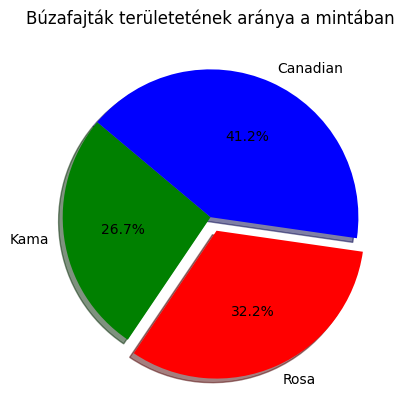

In [49]:
labels = df['buza_fajtaja'].unique().tolist()
sizes = df.groupby('buza_fajtaja')['terulet'].sum().tolist()
colors = ['green', 'red', 'blue']
explode = (0, 0.1, 0)  # A Rosa kicsit kiemelve

# Kördiagram rajzolása
plt.pie(sizes, labels=labels, colors=colors, explode=explode,
        autopct='%1.1f%%', shadow=True, startangle=140) #explode - szelet kiemelése, autopct - százalékok kiírása, 
                                                        #startangle - elforgatja a diagrammot x fokkal.

plt.title("Búzafajták területetének aránya a mintában")
plt.show()

## 2. Fajták átlagos kerülete – oszlopdiagram

A különböző búzafajtákhoz tartozó szemek **átlagos kerületét** hasonlítottam össze oszlopdiagram segítségével. Az ábrán jól látható, hogy melyik fajta esetében a legnagyobb vagy legkisebb a szemek kerülete. Lényeges különbség nem fedezhető fel a területhez képest. A későbbi vizsgálatok során vagy ezt vagy a területet érdemes figyelembe venni, de külön-külön.

Különböző színek lettek rendelve a különböző búzafajtákhoz (`green`, `red`, `blue`), a tengelyeket feliratoztam, és a `tight_layout()` segítségével biztosítottam az elemek megfelelő elhelyezkedését.



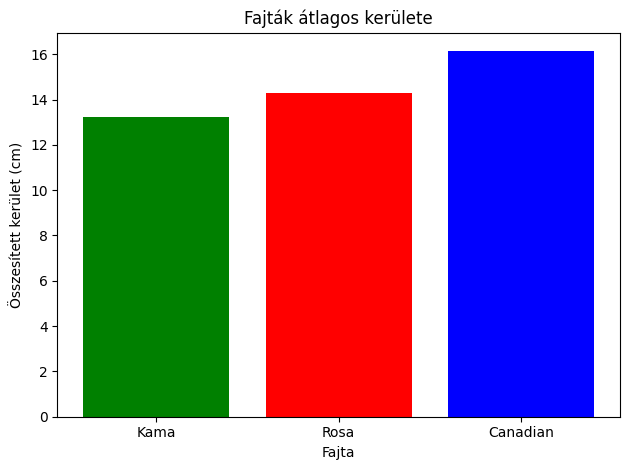

In [50]:
# Színek definiálása fajtánként
labels = df['buza_fajtaja'].unique().tolist()
sizes = df.groupby('buza_fajtaja')['kerulet'].mean().tolist()
colors = ['green', 'red', 'blue']

plt.bar(labels, sizes, color=colors)

# Címek és címkék hozzáadása
plt.title("Fajták átlagos kerülete")
plt.xlabel("Fajta")
plt.ylabel("Összesített kerület (cm)")

# Diagram megjelenítése
plt.tight_layout() # elhelyezi a diagrammokat megfelelően
plt.show()

## 3. Szemhossz és szélesség eloszlása – hisztogram

A búzaszemek **hosszának** és **szélességének** eloszlását hisztogram segítségével vizsgáltam. A `df[features].hist()` metódus két külön ablakban ábrázolja az eloszlásokat. A `figsize=(10,4)` paraméterrel szabályoztam az ábrák méretét (10 egység széles, 4 egység magas).

Ez az ábra segít megérteni, hogy az egyes jellemzők milyen értéktartományban mozognak, illetve az értékek gyakorisági eloszlását is jól mutatja.
A **szemhossz** eloszlása enyhén balra ferdült, jobbra elnyúlik. Ezzel szemben a **szem szélességének** eloszlása közel egyenletes

array([[<Axes: title={'center': 'szemhossz'}>,
        <Axes: title={'center': 'szem_szelesseg'}>]], dtype=object)

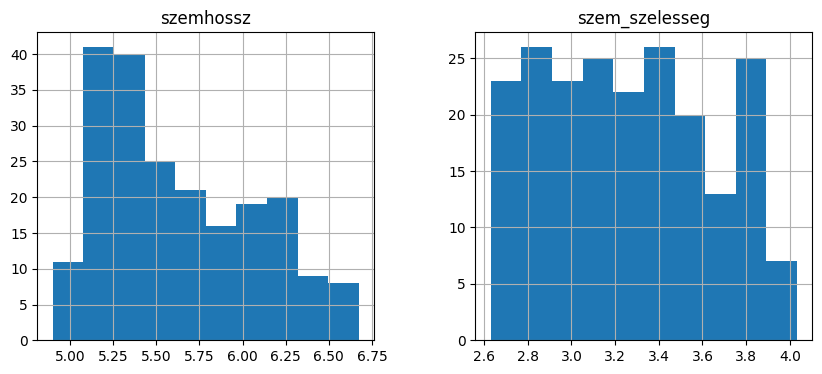

In [51]:
features = ['szemhossz', 'szem_szelesseg']
df[features].hist(figsize=(10,4)) # hisztogramm --> param: 10 széles 4 magas

## 4. Kompaktság eloszlása – hisztogram és dobozdiagram

A **kompaktság** jellemző eloszlását kétféle módon is ábrázoltam, két különböző ábrával:

1. **Hisztogram**: Az eloszlás vizualizálásához a `sns.histplot()` függvényt használtam. Emellett a **Kernel Density Estimate (KDE)** görbét is megjelenítettem, amely segít a sűrűség vizuális értelmezésében.

2. **Boxplot**: A kompaktság jellemzésére készítettem egy vízszintes dobozdiagramot (`sns.boxplot()`), amely jól ábrázolja a mediánt, az alsó és felső kvartiliseket, illetve a kiugró értékeket.

A két ábra együttesen segít jobban megérteni a kompaktság eloszlásának statisztikai tulajdonságait.
A kompaktságról 2 érdekes információ derült ki. Az eloszlása szemmel láthatólag közel standard normális, illetve elég kevés kiugró érték jellemzi.

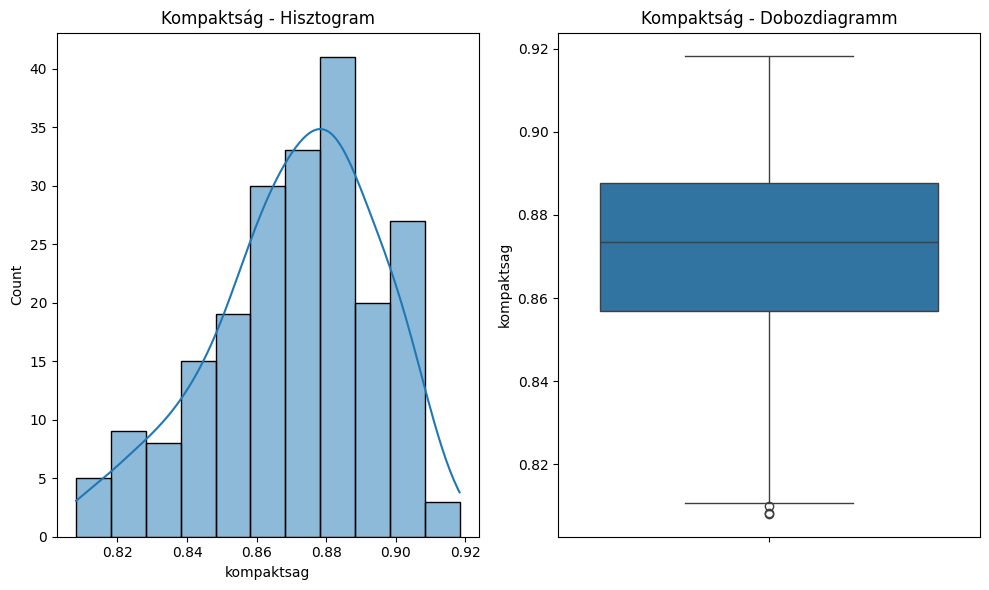

In [52]:
# Ábra létrehozása 1 sorban és 2 oszlopban eltérő méretekkel
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Hisztogram
sns.histplot(df['kompaktsag'], kde=True, ax=axes[0]) #kde - görbét is rajzol
axes[0].set_title('Kompaktság - Hisztogram')

# Boxplot (vízszintes)
sns.boxplot(y=df['kompaktsag'], ax=axes[1]) # y tengely megadásával hosszára rajzolja ki
axes[1].set_title('Kompaktság - Dobozdiagramm')

# Ábra megjelenítése
plt.tight_layout() # elhelyezi a diagrammokat megfelelően
plt.show()

## 5. Korrélációs mátrix – hőtérkép

A numerikus változók közötti **korrélációt** a `df.corr()` függvénnyel vizsgáltam, amely egy négyzetes mátrixot ad vissza, ahol az értékek a változók közötti lineáris kapcsolatot jelzik. Az értékek -1 és 1 között mozognak, ahol 1 teljes pozitív, -1 teljes negatív korrelációt, 0 pedig a korrelálatlanságot jelöli.

A **hőtérkép** (`sns.heatmap()`) segítségével vizualizáltam a korrélációkat, ahol az értékek is megjelennek az egyes cellákban (`annot=True`), hogy könnyen átlássam a változók közötti kapcsolatokat.

A `osztalycimke` oszlopot eltávolítottam a vizualizációból, mivel nem releváns a numerikus változók közötti kapcsolatok elemzésére. A későbbi elemzések során a korrelációs mátrix hasznos lehet.


<Axes: >

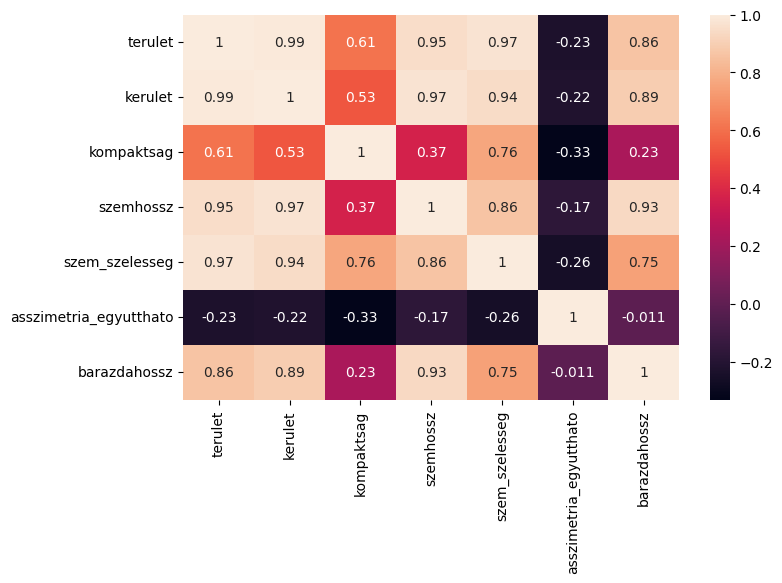

In [53]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix = corr_matrix.drop('osztalycimke',axis=0)
corr_matrix = corr_matrix.drop('osztalycimke',axis=1)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(corr_matrix,annot=True,ax=ax) # annot --> értékek is jelölve vannak

## 6. Szemhossz és barázdahossz közötti kapcsolat – scatterplot

A **szemhossz** és a **barázdahossz** közötti kapcsolatot pontdiagram segítségével vizsgáltam meg. A `sns.scatterplot()` függvényt használtam, amely két változó kapcsolatát ábrázolja pontok formájában. A különböző **búzafajtákat** (`hue='buza_fajtaja'`) eltérő színekkel különböztettem meg hogy lássam, van-e a fajták közötti eltérés. A diagram alapján arra jöttem rá, hogy a `Rosa` típusú búza jelentősen eltér a másik két típustól. Ezt az információt a későbbiekben akár fel is használhatom.


<Axes: xlabel='szemhossz', ylabel='barazdahossz'>

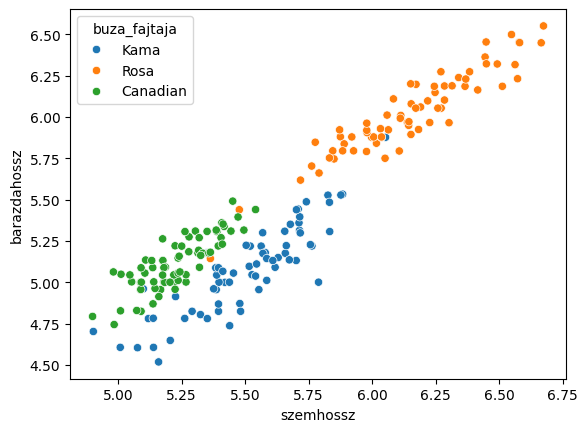

In [54]:
sns.scatterplot(data=df,x='szemhossz',y='barazdahossz', hue='buza_fajtaja')

## 7. Numerikus változók közötti kapcsolatok – pair plot

A numerikus típusú oszlopok közötti kapcsolatokat **pair plot-val** (`sns.pairplot()`) vizsgáltam meg. A `numeric_df` változóba csak a numerikus típusú oszlopokat választottam ki a `df.select_dtypes(include='number')` segítségével, és a `sns.pairplot()` függvényt használtam a változók közötti összes lehetséges páros kapcsolat vizualizálására.

Ez a diagram minden egyes numerikus változónak az eloszlását is megjeleníti az átlóban, míg a többi cellában az egyes változók közötti pontdiagramját ábrázolja. A **pairplot** segít a többdimenziós adatok gyors áttekintésében és a lehetséges korrelációk, valamint a fajták közötti különbségek felismerésében. A `osztalycimke` oszlopot eltávolítottam a vizualizációból, mivel nem releváns a numerikus változók közötti kapcsolatok elemzésére.

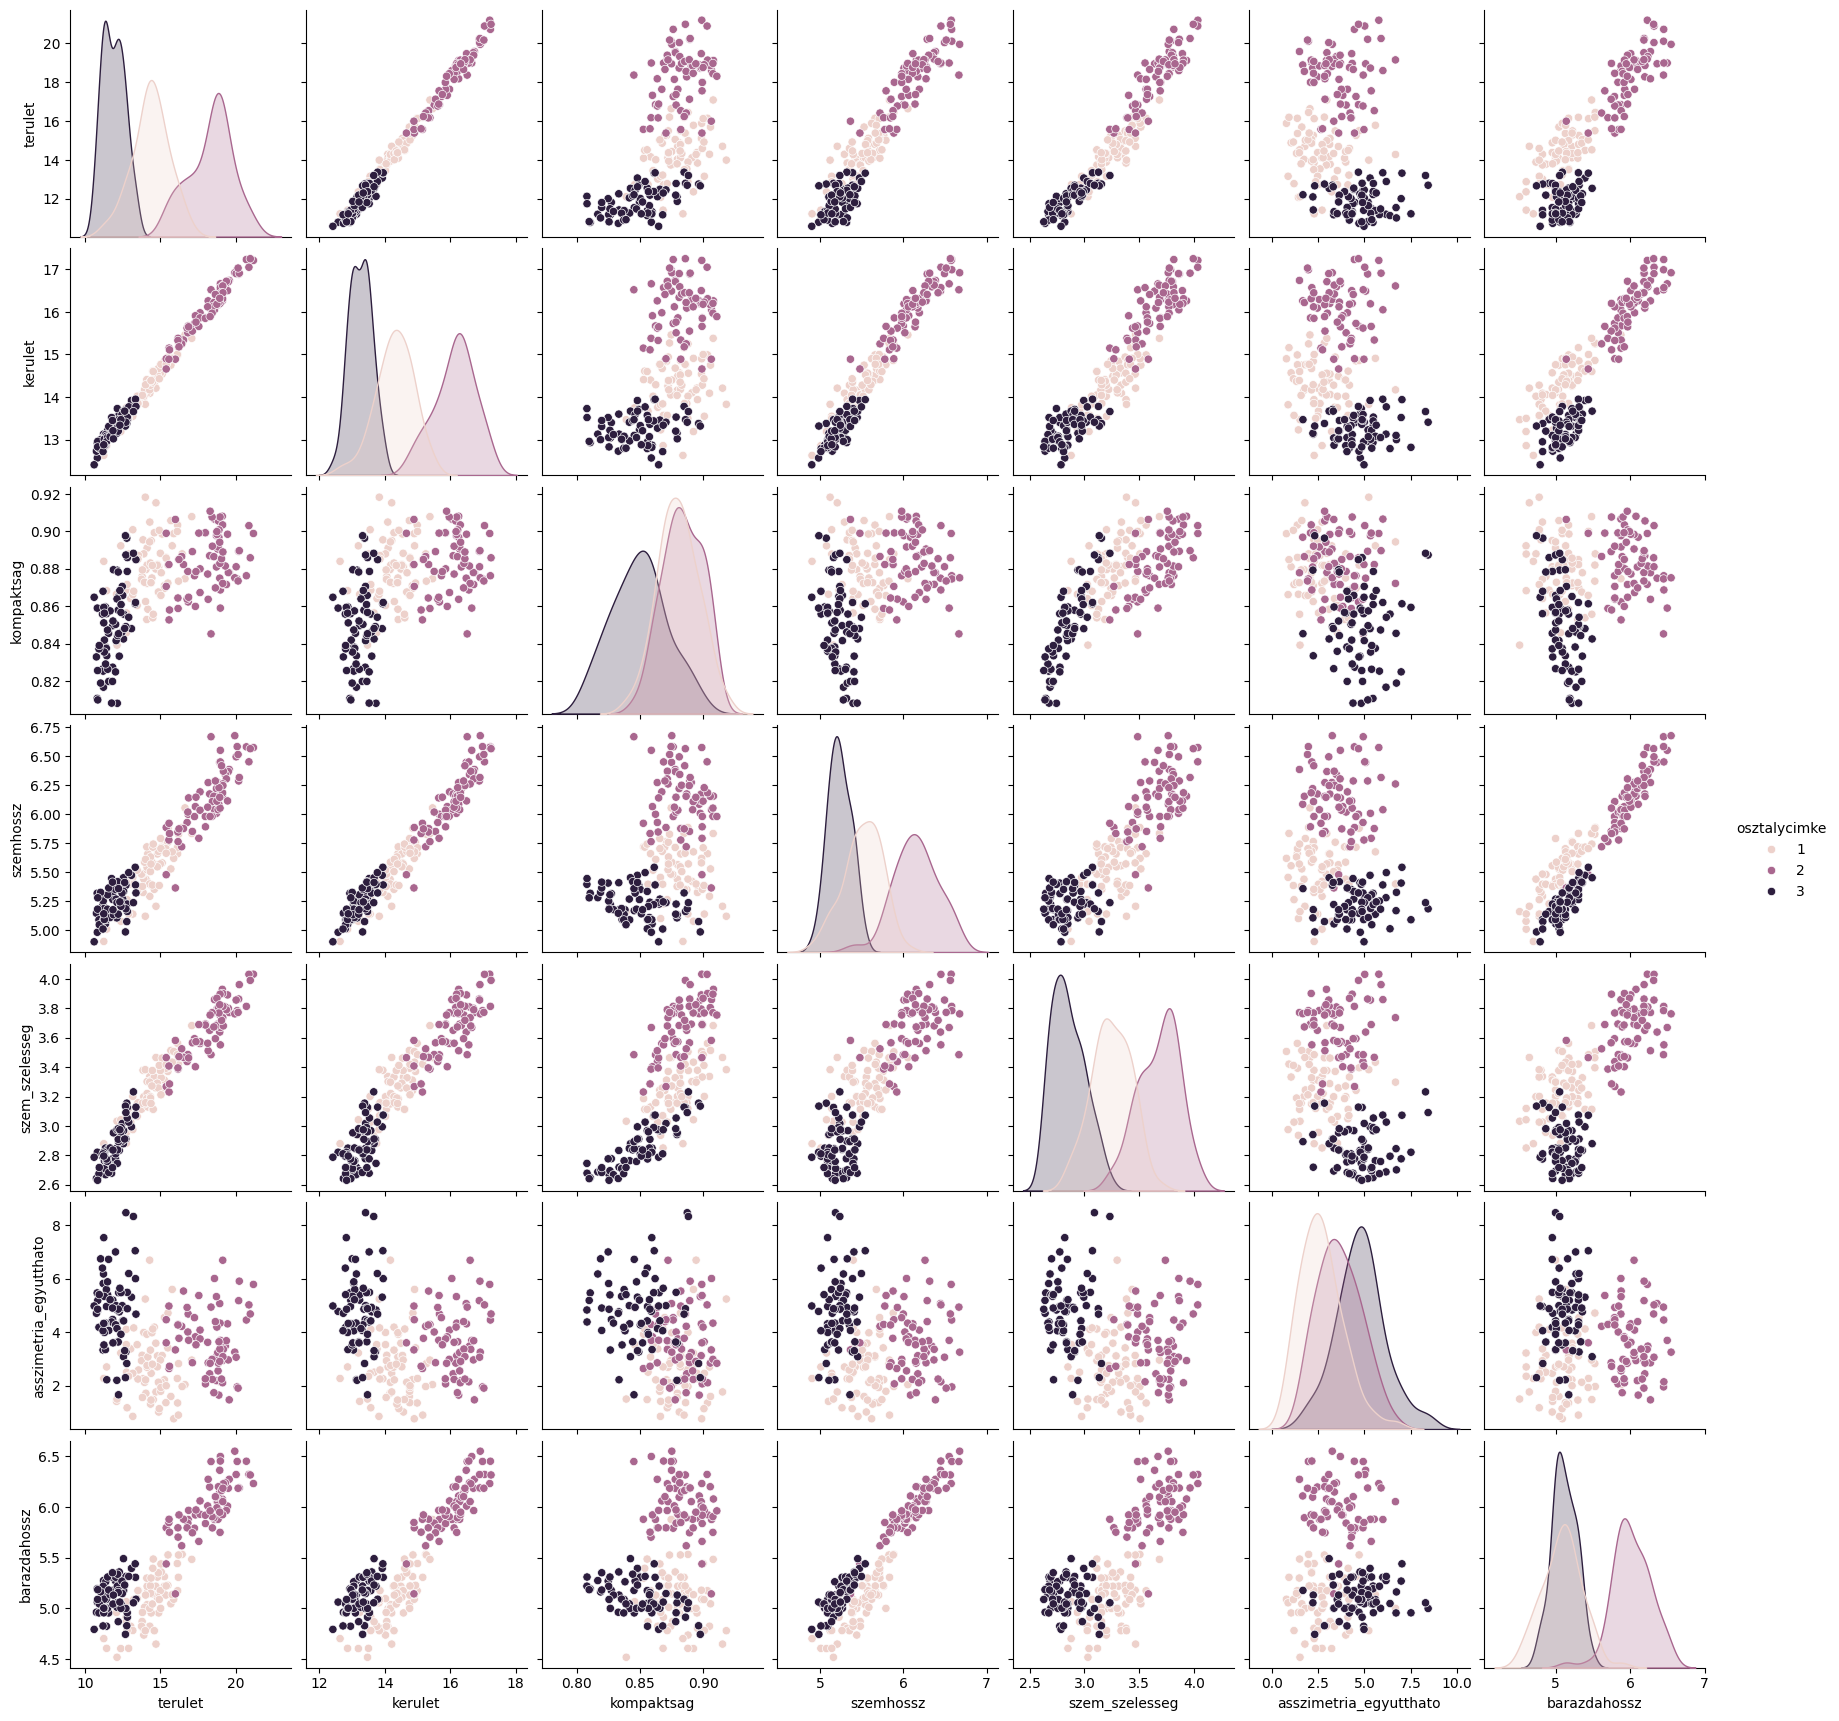

In [55]:
# Csak a numerikus típusú oszlopok kiválasztása

numeric_df = df.select_dtypes(include='number')
sns.pairplot(numeric_df, hue='osztalycimke')

# Klaszterezés 
## 1. - K-közép (K-means)

### Mi a K-közép algoritmus?

A **K-közép (K-means)** egy **nem felügyelt (unsupervised)** gépi tanulási algoritmus, amelyet **klaszterezés** céljából használunk. Az algoritmus célja, hogy az adatokat előre meghatározott számú csoportba (klaszterekbe) rendezze úgy, hogy minden adatpont a legközelebbi középponthoz (centroidhoz) kerüljön.

### Hogyan működik a K-közép algoritmus?

A K-közép algoritmus a következő lépéseken keresztül végzi el a klaszterezést:

1. **Kezdeti középpontok kiválasztása**: Az algoritmus először véletlenszerűen kiválaszt egy számú (K) középpontot az adatokból. Minden középpont egy klaszter "középpontját" jelenti.

2. **Pontok hozzárendelése a legközelebbi középponthoz**: Minden adatpontot hozzárendelünk a legközelebbi középponthoz. Ez alapján az adatokat K darab klaszterre osztjuk.

3. **Középpontok újraszámítása**: Az új klaszterek alapján minden klaszter középpontját újraszámítjuk. A középpontot úgy számítjuk ki, hogy az összes hozzá tartozó adatpont átlagát vesszük.

4. **Újraszámolás és hozzárendelés ismétlése**: Az új középpontok alapján ismét hozzárendeljük az adatokat a legközelebbi középponthoz, és újraszámoljuk a középpontokat. Ezt a folyamatot addig ismételjük, amíg a középpontok már nem változnak jelentősen.

### Mire jó a K-közép algoritmus?

- **Adatok csoportosítása**: A K-közép klaszterezés segítségével az adatokat természetes csoportokba rendezhetjük. Ez hasznos lehet például piackutatásnál, vásárlói szegmensek meghatározásánál, vagy bármilyen olyan problémánál, ahol az adatokat kategorizálni kell.
  
- **Mintázatok felismerése**: A K-közép segíthet felfedezni olyan rejtett mintázatokat az adatokban, amelyek a csoportosítás révén könnyebben átláthatóvá válnak.

- **Dimenziócsökkentés és adatredundancia csökkentés**: A klaszterek segítségével kevesebb reprezentatív csoportot használhatunk az adatok összefoglalására, ami csökkentheti az adatok komplexitását.

### Hogyan alkalmazzuk?

Az alábbi példában a **terület** és **asszimetria együttható** jellemzők alapján végeztem klaszterezést a K-közép algoritmus segítségével:
### Eredmény:
A fenti kódban az algoritmus három klaszterre osztotta a búzaszemeket a **terület** és **asszimetria együttható** jellemzők alapján. A diagramon láthatóak a klaszterek, amelyek különböző színekkel vannak jelölve. A csoportosítás relatív jól működött, közel az eredeti adatpontokkal egyeznek meg a csoportcímkék. Későbbiekben ezeket a paramétereket akár a `logisztikus regresszió során is felhasználhatom`

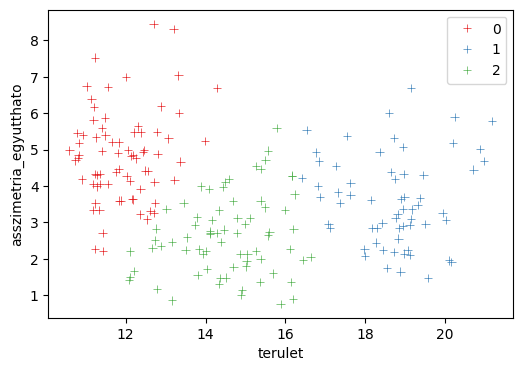

In [56]:
features = ['terulet','asszimetria_egyutthato']
kkozep_df = df[features]
kmeans = KMeans(n_clusters=3)
kmeans.fit(kkozep_df);

plt.figure(figsize=(6,4))
sns.scatterplot(x=kkozep_df['terulet'], y=kkozep_df['asszimetria_egyutthato'], hue=kmeans.labels_, palette="Set1", marker='+'); # pontok kirajzolása

## 2. - DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

### Mi a DBSCAN algoritmus?

A **DBSCAN** egy olyan **nem felügyelt (unsupervised)** klaszterezési algoritmus, amely a sűrűség alapján osztja csoportokra az adatokat. A DBSCAN az adatpontok közötti távolságokat és azok sűrűségét használja, hogy klasztereket hozzon létre. A klasszikus K-közép algoritmushoz képest a DBSCAN előnye, hogy nem szükséges előre meghatározni a klaszterek számát, és képes kezelni a zajos adatokat (azokat az adatokat, amelyek nem illeszkednek egyik klaszterhez sem).

### Hogyan működik a DBSCAN algoritmus?

A DBSCAN két alapvető paraméterrel működik:

1. **Eps (eps)**: Ez a paraméter határozza meg, hogy mekkora lehet a maximális távolság két adatpont között ahhoz, hogy azok ugyanahhoz a klaszterhez tartozzanak. Két adatpont akkor tartozik ugyanahhoz a klaszterhez, ha az egyik pont távolsága a másiktól kisebb, mint az eps érték.
   
2. **Min_samples**: Ez a paraméter meghatározza, hogy hány adatpontnak kell jelen lennie egy klaszter középpontjának (core point) körül ahhoz, hogy az pontot egy klaszterhez rendeljük. Ha egy pont körüli adatpontok száma kevesebb, mint a `min_samples` értéke, akkor azt zajnak tekintjük, és nem tartozik semelyik klaszterhez.

A DBSCAN algoritmus a következő lépésekben működik:
- Az algoritmus elkezd dolgozni egy adatponttal, és megnézi, hogy az adatpont körüli pontok sűrűsége elég nagy-e ahhoz, hogy klasztert képezzenek.
- Ha egy adatpont megfelel a `min_samples`-nak, akkor a körülette lévő adatpontokat hozzárendeljük a klaszterhez, és ezt az eljárást ismételjük.
- Az adatpontok, amelyek nem tartoznak egyik klaszterhez sem (nem elég sűrűek, vagy túl távol esnek a többi ponttól), zajnak számítanak.

### Mire jó a DBSCAN algoritmus?

- **Nem igényel előre meghatározott klaszterszámot**: A DBSCAN egyik előnye, hogy nem szükséges előre meghatározni a klaszterek számát. Az algoritmus az adatpontok közötti sűrűségi különbségek alapján találja meg a klasztereket.
  
- **Zajos adatok kezelése**: A DBSCAN jól kezeli a zajos adatokat, azokat az adatokat, amelyek nem tartoznak egyik klaszterhez sem.

- **Sűrűség alapú klaszterek**: A DBSCAN képes olyan klasztereket találni, amelyek nem feltétlenül kerekek vagy gömb alakúak, így jól alkalmazható nemlineáris eloszlású adatokra.

### Hogyan alkalmazzuk?

Az alábbi kódban a **kompaktság** és **barázdahossz** jellemzők alapján végeztem klaszterezést a DBSCAN algoritmus segítségével. Az **eps** paraméter meghatározza a maximális távolságot, amelyen belül a pontok hozzárendelhetők a klaszterekhez, míg a **min_samples** az adott klaszterek minimális adatpontjainak számát szabályozza. Sajnos ezt az algoritmust annyira nem sikerült jól használni, a 3. klasztert nem igazán sikerült vele megtalálni. Sovány vigasz, hogy legalább a 2 csoportos elkülönítés egész jóra sikeredett.



<Axes: xlabel='kompaktsag', ylabel='barazdahossz'>

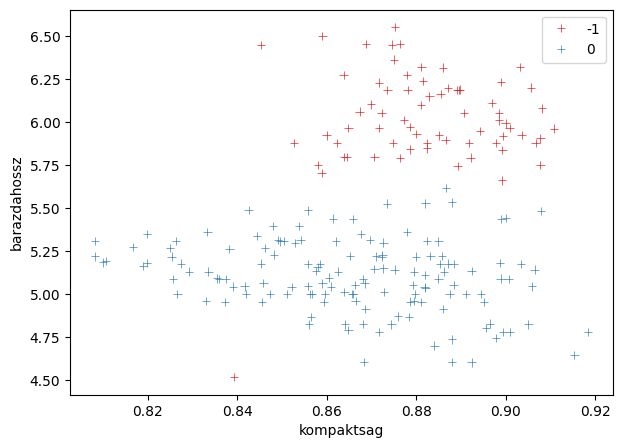

In [57]:
features = ['kompaktsag','barazdahossz']
dbscan_clusters = df[features]
db = DBSCAN(eps=0.25,min_samples=60) # eps: adatpontok közti max távolság, min samples: a középpont körüli pontok minimális értéke
db.fit(dbscan_clusters)
plt.figure(figsize=(7,5))
sns.scatterplot(x=dbscan_clusters['kompaktsag'], y=dbscan_clusters['barazdahossz'], marker='+', hue=db.labels_, palette="Set1")

# Lineáris Regressziós modellek
## 1. modell - Kvadratikus regresszió illesztése

Eddig az elemzésben a `kompaktsag` és a `szem_szelesseg` attribútumok nagy szerepet játszottak, így ezt a lineáris regresszio során szeretném felhasználni. A `kompaktsag` értékét szeretném megbecsülni a `szem_szelesseg` és annak négyzete alapján, ezért létrehoztam egy új változót (`szem_szelesseg2`) néven. Ezután elkészítettem a bemeneti mátrixot, és lefuttattam egy kvadratikus (másodfokú) lineáris regressziót a `LinearRegression` segítségével.


In [58]:
df['szem_szelesseg2'] = df['szem_szelesseg']**2
lin_reg_x = df[['szem_szelesseg','szem_szelesseg2']].to_numpy()
lin_reg_y = df['kompaktsag'].to_numpy()

reg = LinearRegression()
reg.fit(lin_reg_x,lin_reg_y) #regresszió lefuttatása

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


A tanult regressziós modellből kinyertem az együtthatókat (`theta0`, `theta1`, `theta2`), majd ezek felhasználásával kiszámoltam a becsült `kompaktsag` értékeket a kvadratikus regressziós egyenlet alapján.

In [59]:
theta0 = reg.intercept_
theta1 = reg.coef_[0]
theta2 = reg.coef_[1]
h = theta0 + theta1 * df['szem_szelesseg'] + theta2 * df['szem_szelesseg2']  # becsült y

A `scatterplot` segítségével megjelenítettem a valódi adatpontokat (`szem_szelesseg` vs. `kompaktsag`), majd a becsült értékeket (`h`) egy vonallal ábrázoltam, hogy szemléltetni tudjam a kvadratikus regresszió illeszkedését.

<Axes: xlabel='szem_szelesseg', ylabel='kompaktsag'>

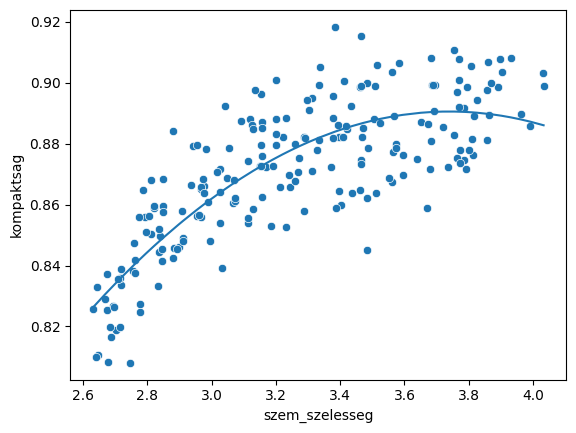

In [60]:
sns.scatterplot(x=df['szem_szelesseg'],y=df['kompaktsag'])
sns.lineplot(x=df['szem_szelesseg'],y=h)

A regressziós modell pontosságát az R² mutatóval értékeltem, amely megmutatja, hogy a modell milyen jól magyarázza a `kompaktsag` változót. Az értéket a `r2_score` függvénnyel számoltam ki. Végeredményként annyira jó illeszkedést nem kaptam, de tragikusnak sem feltétlen nevezném.

In [61]:
r2 = r2_score(df['kompaktsag'], h)
print("R²:", r2)

R²: 0.6675923192313233


## 2. modell - Többváltozós lineáris regresszió illesztése

Ezúttal a `kompaktsag` értékét nemcsak a `szem_szelesseg`, hanem a `terulet` alapján is próbáltam megbecsülni. Ezeket a magyarázó változókat a korrelációs mátrix alapján választottam. A két bemeneti változóból összeállítottam a tanító adatokat, majd lefuttattam a lineáris regressziót.


In [62]:
lin_reg_x = df[['szem_szelesseg','terulet']].to_numpy()
lin_reg_y = df['kompaktsag'].to_numpy()

reg = LinearRegression()
reg.fit(lin_reg_x,lin_reg_y) #regresszió lefuttatása

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


A lineáris regresszió modellből kinyertem az együtthatókat (`theta0`, `theta1`, `theta2`), majd ezeket felhasználva kiszámoltam a becsült `kompaktsag` értékeket a lineáris egyenlet alapján, figyelembe véve a `szem_szelesseg` és `terulet` változókat.

In [63]:
theta0 = reg.intercept_
theta1 = reg.coef_[0]
theta2 = reg.coef_[1]
h = theta0 + theta1 * df['szem_szelesseg'] + theta2 * df['terulet']  # becsült y

### 3D-s Regressziós Ábra Létrehozása
1. **Ábra létrehozása**  
   Létrehoztam egy 3D-s ábrát 7x5 colos méretben, és hozzáadtam egy 3D-s subplotot.

2. **Eredeti adatpontok ábrázolása**  
   A `szem_szelesseg`, `terulet` és `kompaktsag` változók alapján lekértem az adatokat, és kék színnel, félátlátszó pontokkal ábrázoltam őket a 3D térben.

3. **Regressziós sík számítása**  
   Kiszámoltam a regressziós síkot a két bemeneti változó (`szem_szelesseg` és `terulet`) alapján. Az eredményeket egy 30x30-as rácson interpoláltam.

4. **Sík kirajzolása**  
   A regressziós síkot piros színnel, 40%-os átlátszósággal ábrázoltam, hogy jól látható legyen a pontok és a sík közötti összefüggés.

5. **Tengelyek beállítása**  
   Beállítottam a tengelyek feliratait és a Z tengely eltolását, hogy az ábra esztétikusan jelenjen meg.

6. **Ábra megjelenítése**  
   A végén megjelenítettem az elkészült 3D-s regressziós ábrát.

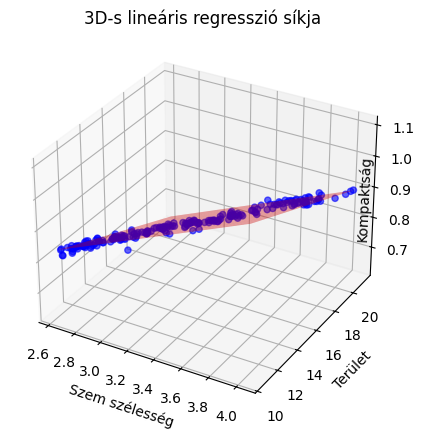

In [64]:
# 1. Ábra létrehozása
fig = plt.figure(figsize=(7, 5))  # Létrehozza a 3D ábrát, 7x5 colos méretben
ax = fig.add_subplot(111, projection='3d')  # Hozzáad egy 3D-s subplotot az ábrához

# 2. Eredeti adatpontok lekérése és kimentése
x = df['szem_szelesseg']  # X tengely adatainak lekérése (szem szélesség)
y_ = df['terulet']  # Y tengely adatainak lekérése (terület)
z = df['kompaktsag']  # Z tengely adatainak lekérése (kompaktság)
ax.scatter(x, y_, z, c='blue', marker='o', alpha=0.6)  # Az adatpontok kirajzolása kék színnel, félátlátszó pontokkal

# 3. Regressziós sík kiszámítása
x_surf, y_surf = np.meshgrid(np.linspace(x.min(), x.max(), 30),  # Az X és Y tengelyekre egy rácsot készítünk
                             np.linspace(y_.min(), y_.max(), 30))  # 30x30-as elrendezésben, a minimum és maximum értékek alapján
z_surf = reg.predict(np.c_[x_surf.ravel(), y_surf.ravel()]).reshape(x_surf.shape)  # A regressziós modell kiszámítja a z értékeket, majd átalakítjuk a megfelelő formátumra

# 4. Sík kirajzolása
ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.4)  # A regressziós sík kirajzolása piros színnel, 40%-os átlátszósággal
ax.zaxis.labelpad = -25  # A Z tengely feliratának eltolása, hogy ne lógjon ki az ábrából

# 5. Tengelyek beállítása
ax.set_xlabel('Szem szélesség')  # X tengely felirata
ax.set_ylabel('Terület')  # Y tengely felirata
ax.set_zlabel('Kompaktság')  # Z tengely felirata
ax.set_title('3D-s lineáris regresszió síkja')  # Az ábra címe

# 6. Az ábra megjelenítése
plt.show()  # Az ábra megjelenítése

Az R² értéket a `r2_score` függvénnyel számoltam ki, amely megmutatja, hogy a regressziós modell mennyire jól magyarázza a `kompaktsag` változót. A kapott érték segít értékelni a modell illeszkedését. Egész jó illeszkedést kaptam, a kompaktságot a területtel és a szem szélességgel tök jól le lehet írni.

In [65]:
r2 = r2_score(df['kompaktsag'], h)
print("R²:", r2)

R²: 0.8783803419575051


# Logisztikus Regresszió modellek

## 1. modell
A `buza_fajtaja` predikcióját a `szemhossz` és a `barazdahossz` alapján végeztem el egy logisztikus regressziós modellel. Már a scatterplot-nál is használtam ezeket az értékeket korábban. A bemeneti változókat összegyűjtöttem és a `LogisticRegression` osztály segítségével illesztettem egy modellt.

In [66]:
log_regression_x = df[['szemhossz','barazdahossz']].to_numpy()
log_regression_y = df['buza_fajtaja'].to_numpy()
reg = LogisticRegression()
reg.fit(log_regression_x,log_regression_y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Először ábrázoltam a `szemhossz` és a `barazdahossz` értékeket színes pontokkal, ahol a színek a `buza_fajtaja` osztályokat reprezentálják. Ezután kiszámoltam a döntési határokat a három osztály (0, 1, 2) között, és azokat elválasztó vonalakkal ábrázoltam. A döntési határok a logisztikus regresszió modell alapján lettek meghatározva, hogy láthatóvá váljon, hogyan választja el a modell az egyes osztályokat a bemeneti változók (`szemhossz`, `barazdahossz`) segítségével. A tengelyeket is megfelelően beállítottam, hogy az ábra jól átlátható legyen.

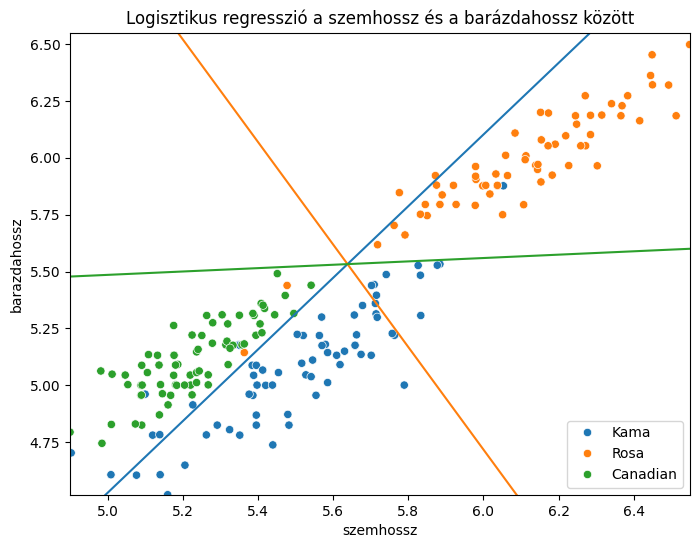

In [67]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['szemhossz'], y=df['barazdahossz'], hue=df['buza_fajtaja'])

# Osztálypárok közötti döntési határok
for i, j in [(0, 1), (0, 2), (1, 2)]:

    # Döntési határegyenlet kiszámítása
    theta0 = reg.intercept_[i] - reg.intercept_[j]
    theta1 = reg.coef_[i, 0] - reg.coef_[j, 0]
    theta2 = reg.coef_[i, 1] - reg.coef_[j, 1]

    y_vals = -(theta0 + theta1 * df['szemhossz']) / theta2 # logisztikus regresszió y pontjainak a kiszámítása
    sns.lineplot(x=df['szemhossz'], y=y_vals)

# Tengelyhossz beállítása
plt.ylim(df['barazdahossz'].min(), df['barazdahossz'].max())
plt.xlim(df['szemhossz'].min(), df['barazdahossz'].max())
plt.title('Logisztikus regresszió a szemhossz és a barázdahossz között')
plt.show()


A logisztikus regresszió modell pontosságát az `accuracy` metrikával értékeltem, amely megmutatja, hogy a modell hány esetben találta el helyesen a `buza_fajtaja` osztályokat. Az eredményt százalékos formában jelenítettem meg. A modellem pontossága lenyűgöző.

In [68]:
accuracy = reg.score(log_regression_x, log_regression_y)
print(f"Pontosság: {accuracy:.2%}")

Pontosság: 94.76%


## 2. modell
Ezúttal a `buza_fajtaja` predikcióját a `terulet` és az `asszimetria_egyutthato` változók alapján végeztem el. Ezeket a változókat szintén használtam már a korábbi elemzések során. A bemeneti adatokat előkészítettem és a `LogisticRegression` modell segítségével illesztettem egy modellt.

In [69]:
log_regression_x = df[['terulet','asszimetria_egyutthato']].to_numpy()
log_regression_y = df['buza_fajtaja'].to_numpy()
reg = LogisticRegression()
reg.fit(log_regression_x,log_regression_y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


A `terulet` és `asszimetria_egyutthato` változók közötti kapcsolatot **scatterplot** segítségével ábrázoltam, ahol a pontok színei a `buza_fajtaja` osztályokat jelölik. Ezután kiszámítottam a három osztály közötti döntési határokat, és ábrázoltam őket vonalakként, hogy szemléltessem, hogyan választja el a modell az egyes osztályokat a bemeneti változók alapján.
A tengelyeket a megfelelő skálára állítottam, hogy az ábra tisztán látható legyen, és a címben is szerepel a modell és a változók közötti kapcsolat.

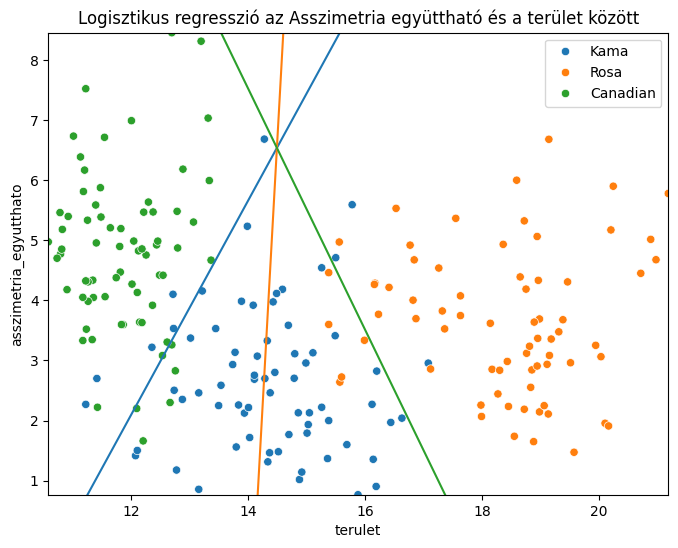

In [70]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['terulet'], y=df['asszimetria_egyutthato'], hue=df['buza_fajtaja'])

# Osztálypárok közötti döntési határok
for i, j in [(0, 1), (0, 2), (1, 2)]:

    # Döntési határegyenlet kiszámítása
    theta0 = reg.intercept_[i] - reg.intercept_[j]
    theta1 = reg.coef_[i, 0] - reg.coef_[j, 0]
    theta2 = reg.coef_[i, 1] - reg.coef_[j, 1]

    y_vals = -(theta0 + theta1 * df['terulet']) / theta2 # logisztikus regresszió y pontjainak a kiszámítása
    sns.lineplot(x=df['terulet'], y=y_vals)

# Tengelyhossz beállítása
plt.ylim(df['asszimetria_egyutthato'].min(), df['asszimetria_egyutthato'].max())
plt.xlim(df['terulet'].min(), df['terulet'].max())
plt.title('Logisztikus regresszió az Asszimetria együttható és a terület között')
plt.show()

A logisztikus regressziós modell pontosságát a tanulóhalmazon az `accuracy` metrikával mértem. Az eredmény megmutatja, hogy a modell hány esetben találta el helyesen a `buza_fajtaja` osztályokat a bemeneti változók (`terulet` és `asszimetria_egyutthato`) alapján. Az értéket százalékos formában jelenítettem meg. Szintén egy egész jó modellt kaptam, bár az előző jobb volt.

In [71]:
accuracy = reg.score(log_regression_x, log_regression_y)
print(f"Pontosság: {accuracy:.2%}")

Pontosság: 90.95%


# Random Forest

A Random Forest egy ensemble (együttműködő) gépi tanulási módszer, amely több döntési fát kombinál a predikciókhoz. Minden fa különböző adatmintákon és változókon tanul, majd a fák eredményeit aggregálja, hogy végső döntést hozzon. 

Ez a módszer csökkenti a túlilleszkedés (overfitting) kockázatát, mivel az egyes fák nem azonos adatokon alapulnak. A Random Forest robusztus, pontos és jól működik nagy, változatos adathalmazokkal. Különösen hasznos, ha vegyes típusú (numerikus és kategóriás) változókat kell kezelni.

A modellhez használt adatokat előkészítettem: eltávolítottam az `osztalycimke` és `buza_fajtaja` oszlopokat a bemeneti változókból (`X`), míg a célváltozóként a `buza_fajtaja` oszlopot választottam (`y`). A többi oszlopot megtartottam, mivel ez az algoritmus nem igényli feltétlen a megfelelő attribútumok kiválasztását. Ezután az adatokat véletlenszerűen felosztottam tanuló- és tesztadatokra 80%-20% arányban a `train_test_split` függvény segítségével, miközben biztosítottam, hogy az osztályok arányai a tesztadatokban is megtartódjanak (`stratify=y`).

In [72]:
X = df.drop(['osztalycimke', 'buza_fajtaja'], axis=1)
y = df['buza_fajtaja']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

A Random Forest osztályozó modellt (`RandomForestClassifier`) 100 döntési fával hoztam létre, és a `random_state=42` biztosítja az ismételhetőséget. A modellt a tanuló adatokon (`X_train`, `y_train`) betanítottam, hogy megtanulja az osztályozási szabályokat.

In [73]:
clf = RandomForestClassifier(n_estimators=100, random_state=10)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Modell predikciók és eredmények kiértékelése

A tesztadatok (`X_test`) alapján előrejelzéseket készítettem a modell segítségével (`y_pred`). Az eredményeket több metrikával is kiértékeltem:

- **Pontosság (Accuracy)**: A modell helyes osztályozásainak arányát mértem az `accuracy_score` segítségével.
- **F1-score (weighted)**: Az F1-score-t is kiszámoltam, amely a pontosság és a visszahívás harmonikus átlaga, súlyozva az osztályok arányával.
- **Confusion Matrix**: A `confusion_matrix` függvénnyel a modell hibáit is vizsgáltam, amely segít az osztályok közötti tévesztések azonosításában.

Végül részletes osztályozási jelentést (`classification_report`) is generáltam, amely tartalmazza az egyes osztályokhoz tartozó pontos és visszahívási mutatókat. A modellem minden tekintetben egész jól teljesített.


In [74]:
y_pred = clf.predict(X_test)

# Eredmények kiértékelése
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print("Pontosság (Accuracy):", acc)
print("F1-score (weighted):", f1)
print("\nRészletes jelentés (classification report):")
print(classification_report(y_test, y_pred))

Pontosság (Accuracy): 0.8809523809523809
F1-score (weighted): 0.8808003405704555

Részletes jelentés (classification report):
              precision    recall  f1-score   support

    Canadian       0.80      0.86      0.83        14
        Kama       0.85      0.79      0.81        14
        Rosa       1.00      1.00      1.00        14

    accuracy                           0.88        42
   macro avg       0.88      0.88      0.88        42
weighted avg       0.88      0.88      0.88        42



A modell teljesítményét vizualizáltam egy **Confusion Matrix** segítségével, amely megmutatja, hogyan osztályozza helyesen és tévesen a különböző osztályokat. A `heatmap` segítségével ábrázoltam a mátrixot, ahol az annotációk az egyes cellákban szereplő értékeket jelenítik meg. A színek intenzitása segít a hibák és helyes osztályozások könnyebb azonosításában. A tengelyek az osztályok valódi és előrejelzett értékeit mutatják, így gyorsan áttekinthetjük, hogy mely osztályok esetén történt téves predikció.

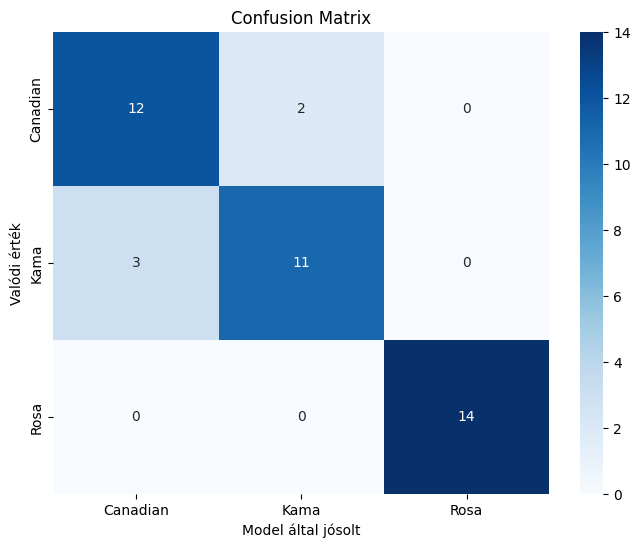

In [75]:
# Confusion Matrix vizualizálása
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Model által jósolt')
plt.ylabel('Valódi érték')
plt.title('Confusion Matrix')
plt.show()

# Gradient Boosting
A Gradient Boosting egy ensemble módszer, amely sorozatosan épít fel általában döntési fákat úgy, hogy az előző modell hibáit próbálja korrigálni. A különböző modellek súlyozott összege alapján hozza meg a végső döntést. 
Ez a technika rendkívül hatékony, különösen, ha az adatok komplexek és nagy hibákat tartalmaznak. A Gradient Boosting képes a modellek finomhangolására, hogy azok jobban alkalmazkodjanak az adatokhoz, és jobb predikciókat adjanak.

A modellt az `osztalycimke` és `buza_fajtaja` oszlopok eltávolításával készítettem elő. Ez az algoritmus sem igényelte a megfelelő attribútumok kiválasztását. Az adatokat két részre osztottam: a bemeneti változók (`X`) az összes többi oszlopot tartalmazzák, míg a célváltozó (`y`) a `buza_fajtaja` oszlopot jelöli. Ezután az adatokat véletlenszerűen felosztottam tanuló- és tesztadatokra 80%-20% arányban


In [76]:
X = df.drop(['osztalycimke', 'buza_fajtaja'], axis=1)
y = df['buza_fajtaja']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

A Gradient Boosting osztályozó modellt (`GradientBoostingClassifier`) 100 döntési fával hoztam létre, és a `random_state=42` biztosítja az ismételhetőséget. A modellt a tanuló adatokon (`X_train`, `y_train`) illesztettem, hogy megtanulja az osztályozási szabályokat. A Gradient Boosting algoritmus fokozatosan javítja a predikciókat azáltal, hogy minden új fa a korábbi modellek hibáit próbálja minimalizálni.


In [77]:
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train, y_train)



,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


### Gradient Boosting modell eredményeinek kiértékelése

A tesztadatokon (`X_test`) a Gradient Boosting modell előrejelzéseit (`y_pred_gb`) készítettem el. Az eredményeket több metrikával is kiértékeltem:

- **Pontosság (Accuracy)**: Az `accuracy_score` segítségével megmértem, hogy a modell hány esetben osztályozott helyesen.
- **F1-score (weighted)**: Az F1-score-t is kiszámoltam, amely az osztályok súlyozott harmonikus átlagát adja meg, figyelembe véve a pontos és visszahívási mutatókat.
- **Confusion Matrix**: A `confusion_matrix` függvénnyel ellenőriztem, hogy hány téves osztályozás történt a különböző osztályok között.

Végül egy részletes osztályozási jelentést (`classification_report`) generáltam, amely tartalmazza az egyes osztályokhoz tartozó teljesítményeket.


In [78]:
y_pred_gb = gb_clf.predict(X_test)

# Eredmények kiértékelése
acc = accuracy_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb, average='weighted')
cm = confusion_matrix(y_test, y_pred_gb)

print("Pontosság (Accuracy):", acc)
print("F1-score (weighted):", f1)
print("\nRészletes jelentés (classification report):")
print(classification_report(y_test, y_pred_gb))

Pontosság (Accuracy): 0.9285714285714286
F1-score (weighted): 0.9277419354838711

Részletes jelentés (classification report):
              precision    recall  f1-score   support

    Canadian       0.82      1.00      0.90        14
        Kama       1.00      0.79      0.88        14
        Rosa       1.00      1.00      1.00        14

    accuracy                           0.93        42
   macro avg       0.94      0.93      0.93        42
weighted avg       0.94      0.93      0.93        42



### Confusion Matrix vizualizálása

A Gradient Boosting modell teljesítményének vizualizálására **Confusion Matrix**-et használtam. A `heatmap` segítségével ábrázoltam a mátrixot, amely megmutatja, hogyan osztályozta a modell a különböző osztályokat. Az annotációk (számok) az egyes cellákban jelzik a valódi és előrejelzett értékek közötti kapcsolatot.

A tengelyek az osztályok valódi és előrejelzett értékeit mutatják, míg a színskála segít az osztályozás pontosságának megértésében. A cél az, hogy minél több helyes osztályozás jelenjen meg, míg a tévesztések a főátlótól távol esnek.

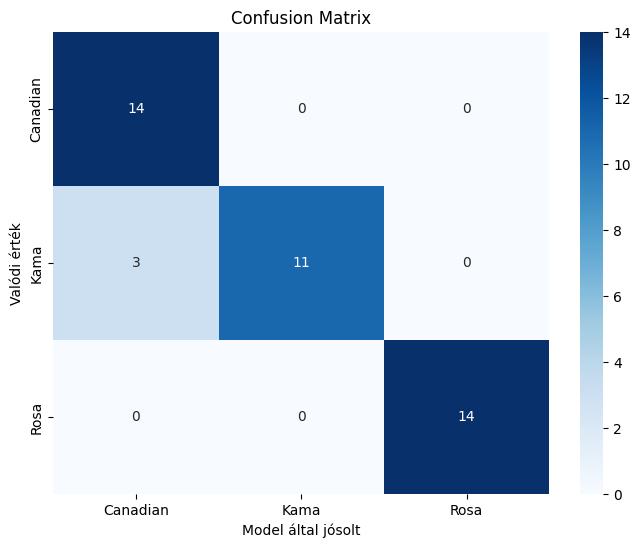

In [79]:
# Confusion Matrix vizualizálása
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Model által jósolt')
plt.ylabel('Valódi érték')
plt.title('Confusion Matrix')
plt.show()

# Neurális Háló

### Adatok előkészítése

- **Bemeneti és célváltozók szétválasztása**  
  Az `X` változó tartalmazza az összes numerikus jellemzőt, az `osztalycimke` és `buza_fajtaja` oszlopok kivételével.  
  A `y` változó az `osztalycimke` oszlop, amelyet 0-alapú indexeléssé alakítottam (`1 → 0`, `2 → 1`, `3 → 2`).

- **One-hot kódolás**  
  A célváltozót (`y`) one-hot formátumra alakítottam a `to_categorical` függvénnyel, így a három osztály külön bináris vektorként szerepel.

- **Tanító- és teszthalmazra bontás**  
  Az adatokat `train_test_split` segítségével osztottam fel 80% tanító és 20% teszt részre.  
  A `stratify=y` beállítással biztosítottam, hogy az osztályok aránya mindkét halmazban megegyezzen.

- **Standardizálás**  
  A bemeneti jellemzőket `StandardScaler` segítségével skáláztam, így minden feature 0 átlagra és 1 szórásra lett normalizálva.  
  A scaler-t a tanítóhalmazon illesztettem (`fit_transform`), majd a teszthalmazt ugyanazzal a transzformációval skáláztam (`transform`).


In [89]:
# X és y
X = df.drop(columns=['osztalycimke','buza_fajtaja','szem_szelesseg2'])
y = df['osztalycimke'] - 1  # 0,1,2 formátum



# One-hot encoding
y_cat = to_categorical(y, num_classes=3)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

# Standardizálás
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Neurális háló felépítése és konfigurálása

- **Modell architektúra** (`Sequential`):  
  - **Dense(16, relu)**: Első, teljesen kapcsolt réteg 16 neuronnal és ReLU aktivációval.  
    - `input_shape` a bemenetek dimenzióját adja meg (az összes numerikus jellemző száma).
  - **Dropout(0.2)**: 20%-os dropout a túltanulás csökkentésére.
  - **Dense(8, relu)**: Második rejtett réteg 8 neuronnal és ReLU aktivációval.
  - **Dense(3, softmax)**: Kimeneti réteg 3 neuronnal (három osztály), softmax aktivációval a valószínűségek kiszámításához.

- **Model kompilálása**:  
  - **Optimizer**: `adam` – adaptív tanulási rátával rendelkező optimalizáló algoritmus.
  - **Loss függvény**: `categorical_crossentropy` – többosztályos osztályozási feladatokra.
  - **Metrika**: `accuracy` – a helyes előrejelzések aránya.


In [90]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/home/lacithelaci/prog1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Modell tanítása korai megállítással (Early Stopping)

- **Korai megállítás beállítása** (`EarlyStopping`):
  - `monitor='val_loss'`: A validációs veszteséget figyeli.
  - `patience=10`: Ha 10 egymást követő epoch során nincs javulás a validációs veszteségben, a tanítás leáll.
  - `restore_best_weights=True`: A modell súlyai automatikusan visszaállnak a legjobb (legalacsonyabb validációs veszteségű) állapotra.

- **Model tanítása** (`fit`):
  - `validation_split=0.2`: A tanítóhalmaz 20%-át validációs adatokra használja.
  - `epochs=100`: Maximum 100 epoch fut, de az EarlyStopping miatt ez hamarabb leállhat.
  - `batch_size=8`: Egyszerre 8 minta kerül feldolgozásra egy batch-ben.
  - `callbacks=[early_stop]`: Aktiválja a korai megállítást.


In [91]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,   # 10 egymást követő epochon nincs javulás → stop
                           restore_best_weights=True)


history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.2239 - loss: 1.0309 - val_accuracy: 0.4118 - val_loss: 0.9596
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4925 - loss: 0.9354 - val_accuracy: 0.7941 - val_loss: 0.8591
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7090 - loss: 0.8603 - val_accuracy: 0.8235 - val_loss: 0.7714
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8134 - loss: 0.7862 - val_accuracy: 0.8529 - val_loss: 0.6886
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8358 - loss: 0.7352 - val_accuracy: 0.8529 - val_loss: 0.6107
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8657 - loss: 0.6505 - val_accuracy: 0.8529 - val_loss: 0.5466
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8507 - loss: 0.6266 - val_accuracy: 0.8529 - val_loss: 0.4976
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8731 - loss: 0.5760 - val_accuracy: 0.

In [93]:
print(f"Teszthalmaz pontosság: {acc:.6f}")

Teszthalmaz pontosság: 0.928571


### Modell és scaler mentése mappába

- **Mappa létrehozása**  
  Az adatok és modell rendezett tárolása érdekében először ellenőrzöm, hogy létezik-e a `model` nevű mappa.  
  Ha nem létezik, akkor létrehozom azt az `os.makedirs` segítségével.

- **Modell mentése**  
  A Keras modell `.h5` formátumban kerül elmentésre a `model` mappába.

- **Scaler mentése**  
  A StandardScaler objektumot `pickle`-lal mentem el ugyanoda, hogy később Streamlit vagy más alkalmazás egyszerűen betölthesse.


In [94]:
import os
import pickle

if not os.path.exists('model'):
    os.makedirs('model')

model.save('model/my_model.h5')

with open('model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)